In [0]:
! nvidia-smi

Sat May 23 16:57:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import seaborn as sns
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
sns.set()

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("****apex module does not exist..hence installing*****")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

import albumentations
print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.5"
if albumentations.__version__ != album_version_needed:
  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)

!pip install kornia
from kornia.losses import SSIM
!git clone https://github.com/Po-Hsun-Su/pytorch-ssim

****apex module does not exist..hence installing*****
  Cloning https://www.github.com/NVIDIA/apex to /tmp/pip-req-build-tln6kknw
  Running command git clone -q https://www.github.com/NVIDIA/apex /tmp/pip-req-build-tln6kknw
  Running command git submodule update --init --recursive -q
  Created wheel for apex: filename=apex-0.1-cp36-none-any.whl size=177472 sha256=a469838f0aff9718f47da1ee4915e0949d2b189d4d0aad754517cd9422a7bcca
  Stored in directory: /tmp/pip-ephem-wheel-cache-fsmm_9t0/wheels/08/3e/36/a75a9914e497fe42598f9dbe67496b2b300a8851f4d396a285
Successfully built apex
0.1.12
     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 634kB 6.9MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=e805215b8f50ee77c8e2f99d34f259648252be85e32eefc539a62b1aeb87212f
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: 

Pytorch version: 1.5.0+cu101
     |████████████████████████████████| 163kB 2.6MB/s 
Cloning into 'pytorch-ssim'...
remote: Enumerating objects: 60, done.
remote: Total 60 (delta 0), reused 0 (delta 0), pack-reused 60
Unpacking objects: 100% (60/60), done.


In [0]:
t1 = time()
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Mask_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Depth_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/BG_and_Its_Flip.zip"
t2 = time()
print(f'FG_BG, Mask & Depth Copy took {(t2-t1)/60:.5f} minutes')

FG_BG, Mask & Depth Copy took 5.67042 minutes


In [0]:
if os.path.exists('/content/FG_BG_Filename_withflip_Logs.txt'):
    print('Log file exists')    
else:  
    !cp '/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Filename_withflip_Logs.txt' '/content/'
    print('Copied Log File') 

Copied Log File


In [0]:
log_fg_bg = open('/content/FG_BG_Filename_withflip_Logs.txt',"r")
content_list = log_fg_bg.readlines()
print('No: of records in log_fg_bg:',len(content_list))
print(content_list[0])
log_fg_bg.close()

data_root = Path('/content')
f1, f2, f3, f4 = data_root/'FG_BG_400K', data_root/'BG_and_Its_Flip', data_root/'FG_BG_Mask_400K',  \
                 data_root/'FG_BG_Depth_0_400K'

No: of records in log_fg_bg: 400000
Img_fg_bg_1.jpg,Img21.jpg,Image41.png,(192, 192, 108, 156, 51, 3, 159, 3, 51, 159, 159, 159)



In [0]:
print(len(list(f1.iterdir())))
print(len(list(f2.iterdir())))
print(len(list(f3.iterdir())))
print(len(list(f4.iterdir())))

400000
200
400000
400000


In [0]:
bs   = 96
bs_small = 8
rows = 5
prnt, save = 1500, 500
t0, t20k, t40k, t80k, t120k, t160k, t200k, t240k, t280k, t320k, t400k  = 0, 20000, 40000, 80000, 120000, 160000, \
                                                                                                 200000, \
                                                                                    240000, 280000, 320000, \
                                                                                                    400000                       

In [0]:
maskdepth_transform_mini = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.ToTensor(),])
bg_transform_mini = transforms.Compose([transforms.Resize((64,64)),
                                       transforms.ColorJitter(brightness =0.05,contrast=0.05,saturation=0.05,hue=0.05),
                                       transforms.ToTensor(),
                                       ])
fg_bg_transform_mini = transforms.Compose([transforms.Resize((64,64)),
                                       transforms.ColorJitter(brightness =0.05,contrast=0.05,saturation=0.05,hue=0.05),
                                       transforms.ToTensor(),
                                       ])

In [0]:
maskdepth_transform_small = transforms.Compose([transforms.Resize((96,96)),
                                      transforms.ToTensor(),])
bg_transform_small = transforms.Compose([transforms.Resize((96,96)),
                                       transforms.ColorJitter(brightness =0.05,contrast=0.05,saturation=0.05,hue=0.05),
                                       transforms.ToTensor(),
                                       ])
fg_bg_transform_small = transforms.Compose([transforms.Resize((96,96)),
                                       transforms.ColorJitter(brightness =0.05,contrast=0.05,saturation=0.05,hue=0.05),
                                       transforms.ToTensor(),
                                       ])

In [0]:
maskdepth_transform_orig = transforms.Compose([transforms.Resize((192,192)),
                                      transforms.ToTensor(),])
bg_transform_orig = transforms.Compose([#transforms.Resize((96,96)),
                                       transforms.ColorJitter(brightness =0.05,contrast=0.05,saturation=0.05,hue=0.05),
                                       transforms.ToTensor(),
                                       ])
fg_bg_transform_orig = transforms.Compose([#transforms.Resize((96,96)),
                                       transforms.ColorJitter(brightness =0.05,contrast=0.05,saturation=0.05,hue=0.05),
                                       transforms.ToTensor(),
                                       ])

In [0]:
class Makedata(Dataset):
  def __init__(self,image_path,content_list, start_rec, end_rec, transform1, transform2, transform3, transform4, do_transform=True):
    self.interim      = list(image_path.glob('*.jpg'))
    self.start_rec    = start_rec
    self.end_rec      = end_rec
    self.f1_files     = self.interim[start_rec:end_rec]
    #self.f1_files     = list(f1.glob('*.jpg'))
    self.content_list = content_list
    self.fg_bg_transform   = transform1 
    self.bg_transform      = transform2
    self.mask_transform    = transform3
    self.depth_transform   = transform4
    self.do_transform      = do_transform

  def __len__(self):
    return len(self.f1_files)  

  def __getitem__(self,index):
    fg_bg_name   = self.f1_files[index].stem
    fg_bg_idx    = fg_bg_name.split('_')[-1]
    bg_name      = '/content/BG_and_Its_Flip/' + self.content_list[int(fg_bg_idx)-1].split(',')[1]
    mask_name    = '/content/FG_BG_Mask_400K/' + 'Img_fg_bg_mask' + str(fg_bg_idx) + '.jpg'
    depth_name   = '/content/FG_BG_Depth_0_400K/' + 'Img_fg_bg_' + str(fg_bg_idx) + '_depth.jpg'
    f1_image = Image.open(self.f1_files[index])  
    f2_image = Image.open(f'{bg_name}')
    f3_image = Image.open(f'{mask_name}')
    f4_image = Image.open(f'{depth_name}')

    if self.do_transform:
      f1_image = self.fg_bg_transform(f1_image)
      f2_image = self.bg_transform(f2_image)
      f3_image = self.mask_transform(f3_image)
      f4_image = self.depth_transform(f4_image)

    return {'f1':f1_image, 'f2':f2_image, 'f3':f3_image, 'f4':f4_image}

In [0]:
train_ds_mini  = Makedata(f1, content_list, t0, t280k, \
                          fg_bg_transform_mini, bg_transform_mini, maskdepth_transform_mini, maskdepth_transform_mini)
train_ds_small = Makedata(f1, content_list, t0, t280k, 
                          fg_bg_transform_small, bg_transform_small, maskdepth_transform_small, maskdepth_transform_small)
train_ds_orig  = Makedata(f1, content_list, t0, t280k, 
                          fg_bg_transform_orig, bg_transform_orig, maskdepth_transform_orig, maskdepth_transform_orig)
test_ds_orig   = Makedata(f1, content_list, t280k, t400k, 
                          fg_bg_transform_orig, bg_transform_orig, maskdepth_transform_orig, maskdepth_transform_orig)

In [0]:
train_dl_mini  = DataLoader(train_ds_mini, batch_size = bs, shuffle = True, pin_memory = True)
train_dl_small = DataLoader(train_ds_small, batch_size = bs, shuffle = True, pin_memory = True)
train_dl_orig  = DataLoader(train_ds_orig, batch_size = bs_small, shuffle = True, pin_memory = True)
test_dl_orig   = DataLoader(test_ds_orig, batch_size = bs_small, shuffle = True, pin_memory = True )

In [0]:
images_mini  = next(iter(train_dl_mini))
images_small = next(iter(train_dl_small))
images_orig  = next(iter(train_dl_orig))
images_test  = next(iter(test_dl_orig))

In [0]:
[(k, v.shape) for k, v in images_mini.items()]

[('f1', torch.Size([96, 3, 64, 64])),
 ('f2', torch.Size([96, 3, 64, 64])),
 ('f3', torch.Size([96, 1, 64, 64])),
 ('f4', torch.Size([96, 1, 64, 64]))]

In [0]:
[(k, v.shape) for k, v in images_small.items()]

[('f1', torch.Size([96, 3, 96, 96])),
 ('f2', torch.Size([96, 3, 96, 96])),
 ('f3', torch.Size([96, 1, 96, 96])),
 ('f4', torch.Size([96, 1, 96, 96]))]

In [0]:
[(k, v.shape) for k, v in images_orig.items()]

[('f1', torch.Size([8, 3, 192, 192])),
 ('f2', torch.Size([8, 3, 192, 192])),
 ('f3', torch.Size([8, 1, 192, 192])),
 ('f4', torch.Size([8, 1, 192, 192]))]

In [0]:
[(k, v.shape) for k, v in images_test.items()]

[('f1', torch.Size([8, 3, 192, 192])),
 ('f2', torch.Size([8, 3, 192, 192])),
 ('f3', torch.Size([8, 1, 192, 192])),
 ('f4', torch.Size([8, 1, 192, 192]))]

In [0]:
imgs = images_test['f1']

In [0]:
def show(tensors, figsize= (10,10), *args, **kwargs):
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.show()

In [0]:
def draw_show_and_save(tensors, name, figsize=(15,15), *args, **kwargs):
  try:
    tensors = tensors.detach().cpu()
  except:
    pass
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])

  plt.savefig(name, bbox_inches='tight')
  plt.show()

In [0]:
def draw_and_save(tensors, name, figsize=(15,15), *args, **kwargs):
  try:
    tensors = tensors.detach().cpu()
  except:
    pass
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])

  plt.savefig(name, bbox_inches='tight')
  plt.close()
  #plt.show()

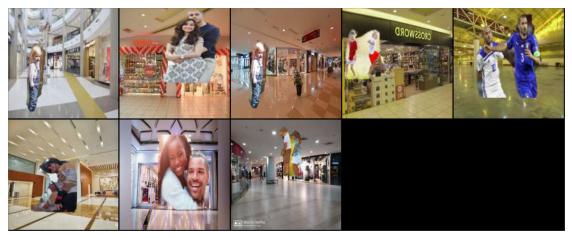

In [0]:
show(imgs, nrow=rows)

In [0]:
class DownSize(nn.Module):
  def __init__(self,inchannels,outchannels):
    super(DownSize, self).__init__()

    self.conv1  = nn.Conv2d(inchannels, outchannels, kernel_size=3, stride=2, padding=1, bias=False)
    self.conv12 = nn.Conv2d(outchannels, outchannels, kernel_size=1, stride=1, padding=0, bias=False)
    self.bn1 = nn.BatchNorm2d(outchannels)
    self.relu = nn.ReLU(inplace=False)

    self.conv2  = nn.Conv2d(outchannels, outchannels, kernel_size=3, stride=1, padding=1, bias=False)
    self.conv22 = nn.Conv2d(outchannels, outchannels, kernel_size=1, stride=1, padding=0, bias=False)
    self.bn2 = nn.BatchNorm2d(outchannels)

    self.conv1x1down = nn.Conv2d(inchannels, outchannels,kernel_size=1, stride=2, padding=0, bias=False)

  def forward(self,x):
    identity = self.conv1x1down(x)
    out = self.conv1(x)
    out = self.conv12(out)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.conv22(out)
    out = self.bn2(out)

    out += identity
    out = self.relu(out)

    return out 

In [0]:
class UpSize(nn.Module):
  def __init__(self, inchannels, outchannels):
    super(UpSize, self).__init__()

    self.conv1 = nn.Conv2d(outchannels, outchannels, kernel_size=3, stride=1, padding=1, bias=False)
    self.conv12 = nn.Conv2d(outchannels, outchannels, kernel_size=1, stride=1, padding=0, bias=False)
    self.bn1 = nn.BatchNorm2d(outchannels)
    self.relu = nn.ReLU(inplace = False)

    self.conv2 = nn.Conv2d(outchannels, outchannels, kernel_size=3, stride=1, padding=1, bias=False)
    self.conv22 = nn.Conv2d(outchannels, outchannels, kernel_size=1, stride=1, padding=0, bias=False)
    self.bn2 = nn.BatchNorm2d(outchannels)

    self.conv1x1down = nn.ConvTranspose2d(inchannels, outchannels, kernel_size=3, stride=1, padding=1, bias=False)

  def forward(self, x):
    identity = self.conv1x1down(x)
    out = self.conv1(identity)
    out = self.conv12(out)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.conv22(out)
    out = self.bn2(out)

    out = self.relu(out)  
    return out

In [0]:
class BGDepth(nn.Module):
  def __init__(self):
    super(BGDepth, self).__init__()


    self.convA = nn.Sequential(nn.Conv2d(in_channels=6,out_channels=32,kernel_size=(3,3),stride=1, 
                                              padding=1, bias= False),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
    self.convB = nn.Sequential(nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3),stride=1,
                                              padding=1,bias=False,groups=32),
                                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(1,1),stride=1,
                                              padding=0,bias=False),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
    self.convC = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=1,
                                              padding=1,bias=False),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
    self.convD = nn.Sequential(nn.Conv2d(in_channels=128,out_channels=64,kernel_size=(3,3),stride=1,
                                              padding=1,bias=False))
    self.convE = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=1,kernel_size=(3,3),stride=1,
                                              padding=1,bias=False))    


    self.blck1 = DownSize(64,128)
    self.blck2 = DownSize(128,256)
    self.blck3 = DownSize(256,256)
    self.blck4 = DownSize(256,256) 
    self.blck5 = UpSize(256, 256)
    self.blck6 = UpSize(256, 256)
    self.blck7 = UpSize(256, 128)
    self.blck8 = UpSize(128, 64)

    self.convLast = nn.Sequential(nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0, bias=False),)

  def forward(self, imgdata):
    fg_bg = imgdata['f1']
    bg    = imgdata['f2']
    #fg_bg = y
    #bg    = y

    f     = torch.cat([fg_bg,bg], dim=1)  # (192,192,6)

    outA = self.convA(f)             #192 (192,192,32)
    outB = self.convB(outA)          #192 (192,192,64)
    outC = self.convC(outB)          #192 (192,192,128)
    outD = self.convD(outC)          #192 (192,192,64)
    outMask = self.convE(outD)       #192 (192,192,1)
	  
    outAD = self.convA(f)            #192 (192,192,32)
    outBD = self.convB(outAD)        #192 (192,192,64)
    outCD = self.convC(outBD)        #192 (192,192,128)  
    outDD = self.convD(outCD)        #192 (192,192,64)
    down1 = self.blck1(outD)         #96  (96,96,128)
    down2 = self.blck2(down1)        #48  (48,48,256)
    down3 = self.blck3(down2)        #24  (24,24,512)
    down4 = self.blck4(down3)        #12  (12,12,512) 

    scale1 = nn.functional.interpolate(down4, scale_factor=2, mode='bilinear')  #(24,24,1024)

    up1 = self.blck5(scale1)   #(24,24,512)         
    up1 += down3               #(24,24,512)
    scale2 = nn.functional.interpolate(up1, scale_factor=2, mode='bilinear') #(48,48,512)
    up2 = self.blck6(scale2) #(48,48,256)
    up2 += down2             #(48,48,256)
    scale3 = nn.functional.interpolate(up2, scale_factor=2, mode='bilinear') #(96,96,256)
    up3 = self.blck7(scale3) #(96,96,128)
    up3 += down1             #(96,96,128)
    scale4 = nn.functional.interpolate(up3, scale_factor=2, mode='bilinear')  #(192,192,128)
    up4 = self.blck8(scale4)        #(192,192,64)
    outDepth = self.convLast(up4)   #(192,192,1)

    return outMask, outDepth

In [0]:
model    = BGDepth()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)

BGDepth(
  (convA): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convB): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convC): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convD): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (convE): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (blck1): DownSize(
  

In [0]:
from torchsummary import summary
summary(model, input_size=(3,192,192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 192]           1,728
       BatchNorm2d-2         [-1, 32, 192, 192]              64
              ReLU-3         [-1, 32, 192, 192]               0
            Conv2d-4         [-1, 32, 192, 192]             288
            Conv2d-5         [-1, 64, 192, 192]           2,048
       BatchNorm2d-6         [-1, 64, 192, 192]             128
              ReLU-7         [-1, 64, 192, 192]               0
            Conv2d-8        [-1, 128, 192, 192]          73,728
       BatchNorm2d-9        [-1, 128, 192, 192]             256
             ReLU-10        [-1, 128, 192, 192]               0
           Conv2d-11         [-1, 64, 192, 192]          73,728
           Conv2d-12          [-1, 1, 192, 192]             576
           Conv2d-13         [-1, 32, 192, 192]           1,728
      BatchNorm2d-14         [-1, 32, 1

In [0]:
criterion1 = nn.BCEWithLogitsLoss()
kernel_size = 3
criterion2 = SSIM(kernel_size, reduction = 'mean')

In [0]:
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9, weight_decay = 1e-5)

In [0]:
def train(model, criterion1, criterion2, device, train_loader, optimizer, epoch, batch_size):
  model.train()
  pbar = tqdm(train_loader)
  num_batches = len(train_loader.dataset)/batch_size
  path_name = '/content/gdrive/My Drive/plots_0523_V8A/'

  for batch_idx, data in enumerate(pbar):
    data['f1'] = data['f1'].to(device)
    data['f2'] = data['f2'].to(device)
    data['f3'] = data['f3'].to(device)
    data['f4'] = data['f4'].to(device)    

    optimizer.zero_grad()
    output = model(data)

 # breakpoint()

    loss1 = criterion1(output[0], data['f3'])
    loss2 = criterion2(output[1], data['f4'])
    loss  = 2*loss1 + loss2

    pbar.set_description(desc = f'{int(epoch)} {int(batch_idx)} l={loss.item():.4f} l1={loss1.item():.5f} l2={loss2.item():.5f}')   
    loss.backward()
    #loss2.backward()
    optimizer.step()
    
    saved = False
    if batch_idx == 0 or batch_idx == int(num_batches-1):
        print('Epoch, Batch_idx:',epoch, batch_idx)
        draw_show_and_save(output[0].detach().cpu(), f'{path_name}{epoch}_{batch_idx}_MP_{loss.item():.5f}.jpg')
        draw_show_and_save(data['f3'].detach().cpu(), f'{path_name}{epoch}_{batch_idx}_MA_{loss.item():.5f}.jpg')
        draw_show_and_save(output[1].detach().cpu(), f'{path_name}{epoch}_{batch_idx}_DP_{loss.item():.5f}.jpg')
        draw_show_and_save(data['f4'].detach().cpu(), f'{path_name}{epoch}_{batch_idx}_DA_{loss.item():.5f}.jpg')
        draw_show_and_save(data['f1'].detach().cpu(), f'{path_name}{epoch}_{batch_idx}_FGBG_{loss.item():.5f}.jpg')      
        saved = True

    if batch_idx % save == 0 and not saved:
        print('Train Epoch: {} Batch_ID: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
               epoch, batch_idx, batch_idx * batch_size, len(train_loader.dataset), 
               (100. * batch_idx / len(train_loader)),
               loss))
        draw_and_save(output[0].detach().cpu(), f'{path_name}{epoch}_{batch_idx}_MP_{loss.item():.5f}.jpg')
        draw_and_save(data['f3'].detach().cpu(), f'{path_name}{epoch}_{batch_idx}_MA_{loss.item():.5f}.jpg')
        draw_and_save(output[1].detach().cpu(), f'{path_name}{epoch}_{batch_idx}_DP_{loss.item():.5f}.jpg')
        draw_and_save(data['f4'].detach().cpu(), f'{path_name}{epoch}_{batch_idx}_DA_{loss.item():.5f}.jpg')
        draw_and_save(data['f1'].detach().cpu(), f'{path_name}{epoch}_{batch_idx}_FGBG_{loss.item():.5f}.jpg')   
      
    path = f'/content/gdrive/My Drive/FG_Depth_Prediction_V8A.pt'
    if batch_idx % 1000 == 0:
      torch.save(model.state_dict(),path)
      print('MODEL SAVED:',path, 'Epoch & Batch-ID:', epoch, batch_idx)

In [0]:
def test(model, criterion1, criterion2, device, test_loader, epoch):
  model.eval()
  test_loss_lst = []
  test_loss1, test_loss2, test_loss = 0, 0, 0
  pbar = tqdm(test_loader)
  path_name = '/content/gdrive/My Drive/plots_0522_V7B/'  

  with torch.no_grad():
    for batch_idx, data in enumerate(pbar):
      data['f1'] = data['f1'].to(device)
      data['f2'] = data['f2'].to(device)
      data['f3'] = data['f3'].to(device)
      data['f4'] = data['f4'].to(device)          

      output = model(data)

  # breakpoint()

      loss1 = criterion1(output[0], data['f3'])
      loss2 = criterion2(output[1], data['f4'])
      loss  = 1.5*loss1 + loss2
      test_loss1 += loss1
      test_loss2 += loss2
      test_loss  += loss

      pbar.set_description(desc = f'{int(epoch)} {int(batch_idx)} tl={loss.item():.4f} tl1={loss1.item():.5f} tl2={loss2.item():.5f}')   
      
      if batch_idx % save == 0 and not saved:
          print('Test Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(test_loader.dataset), (100. * batch_idx / len(test_loader)),
                test_loss))
          draw_and_save(output[0].detach().cpu(), f'{path_name}Test_{epoch}_{batch_idx}_MP_{loss.item():.5f}.jpg')
          draw_and_save(data['f3'].detach().cpu(), f'{path_name}Test_{epoch}_{batch_idx}_MA_{loss.item():.5f}.jpg')
          draw_and_save(output[1].detach().cpu(), f'{path_name}Test_{epoch}_{batch_idx}_DP_{loss.item():.5f}.jpg')
          draw_and_save(data['f4'].detach().cpu(), f'{path_name}Test_{epoch}_{batch_idx}_DA_{loss.item():.5f}.jpg')
          draw_and_save(data['f1'].detach().cpu(), f'{path_name}Test_{epoch}_{batch_idx}_FGBG_{loss.item():.5f}.jpg')       
    
  test_loss /= len(test_loader.dataset)
  test_loss_lst.append(test_loss)

In [0]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=2, gamma=0.1)

In [0]:
import os
path_del   = '/content/plots/'
k = 0
for del_file in os.listdir(path_del):
    os.remove(f'{path_del}{del_file}')
    k += 1
print('total deleted from Plots:',k)

total deleted from Plots: 45


In [0]:
path = f'/content/gdrive/My Drive/FG_Depth_Prediction.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
for epoch in range(1,7):
  if epoch < 5:
     train(model, criterion1, criterion2, model.device, train_dl_mini, optim, epoch, bs)
  elif epoch < 7:
     train(model, criterion1, criterion2, model.device, train_dl_small, optim, epoch, bs)
  else:
     train(model, criterion1, criterion2, model.device, train_dl_orig, optim, epoch, bs_small)    
         
  #test(model, device, test_loader, epoch)
  scheduler.step()  